# Исследование индустрии видеоигр

В проекте по историческим данным о продажах видеоигр из открытых источников необходимо выявить закономерности, определяющие успешность игры.

Структура исходных данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Примечание: данные за 2016 год могут быть неполными

### Открытие файла, изучение общей информации

In [1]:
#Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
#Считал данные из файла и вывел на экран несколько строк:
games_data = pd.read_csv('/datasets/games.csv')
games_data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games_data.info() #Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В данных сразу можно выявить некоторые проблемы:
- Во многих столбцах отсутствуют значения
- Некоторым столбцам нужно изменить тип данных
- Для исключения ошибок в последующей работе стоит переименовать столбцы, используя только строчные буквы

Исправлением этих проблем я займусь далее.

### Подготовка данных

In [4]:
games_data_columns = list(games_data.columns) #Получил список названий столбцов

#Создал новый список названий столбцов только из строчных букв:
new_games_data_columns = []
for i in games_data_columns:
    new_games_data_columns.append(i.lower())

#Переименовал столбцы:
games_data.columns = new_games_data_columns

games_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
#Вручную рассмотрел некоторые строки с пропусками в определенных столбцах:
games_data[games_data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Изучив пропуски в некоторых столбцах можно предложить следующие решения:
- name и genre имеют по два пропуска и они совпали по строкам. Эти две строки можно удалить. На исследование это сильно не повлияет
- В platform нет пропусков, но есть платформы с совсем небольшим количеством игр, возможно стоит исключить некоторые платформы из исследования
- В столбце year обнаружено 269 пропусков. И они мешают перевести тип столбца в более подходящий int. В названиях некоторых игр присутствует год, но он может и не совпадать с годом релиза, вручную искать в интернете год выхода довольно долго. В данных такие пропуски составляют около 1.5%, думаю можно заполнить пропуски индикаторным значением -1 и не рассматривать данные по этому "году" в исследовании
- В столбцах с оценками (critic_score и user_score) пропущена примерно половина значений - это очень много. Можно найти коэффициент корреляции между оценками критиков и пользователей, и если он достаточно большой - заменить пропуск в одном столбце на значение другого, умножив на коэффициент 0.1 или 10 (оценки критиков в стобальной шкале, а пользователей - в десятибальной). Если пропуски будут сразу в двух столбцах, то лучше их не заменять. В столбце user_score есть значения 'tbd' - to be determined. Возможно пользовательский рейтинг игры просто не был рассчитан из-за малого количества оценок. Такие значения мешают перевести столбец из типа object в float. Предлагаю заменить 'tbd' на NaN, чем они по сути и являются.
- В rating отсутствует около трети значений, заменить их по известным данным также не представляется возможным (адекватным для некоторых игр могло бы быть восстановление рейтинга по жанру, но даже спортивные игры и паззлы могут иметь рейтинг от T до M). Кроме того в столбце есть редкие значения: EC и K-A можно заменить на E, что либо близко к нему, либо равнозначно, а AO и RP - на NaN, чтобы они не мешали (для анализа таких игр всё равно недостаточно)

Пропуски в данных могли появиться при ошибке во время выгрузки данных. Возможно также, что базы данных открытых источников изначально имели пропуски или некорректные значения.

In [6]:
#Удалил строки с пропусками в name и genre:
games_data = games_data[~games_data['name'].isna()]

#Заполнил пропуски в year_of_release индикаторным значением:
games_data['year_of_release'] = games_data['year_of_release'].fillna(-1)

#Заменил 'tbd' на NaN:
games_data['user_score'] = games_data['user_score'].replace({'tbd': np.nan})

#Заменил редкие значения рейтинга:
games_data['rating'] = games_data['rating'].replace({'EC': 'E', 'K-A': 'E', 'AO': np.nan, 'RP': np.nan})

In [7]:
#Перевел столбец user_score в тип float:
games_data['user_score'] = games_data['user_score'].astype('float')

#Вычислил коэффициент корреляции между оценками критиков и пользователей:
games_data['critic_score'].corr(games_data['user_score'])

0.5808778320767236

Коэффициент корреляции Пирсона 0.58 указывает на довольно сильную прямую зависимость величин, поэтому мне кажется целесообразным заменить пропуски в столбце user_score на значение из critic_score, и наоборот, умножив оценку соответственно на 0.1 и 10

In [8]:
#Заменил пропуски в столбцах с оценками:
games_data.loc[((games_data['critic_score'].isna()) & (~games_data['user_score'].isna())), 'critic_score'] = (
    games_data['user_score']*10)

games_data.loc[((~games_data['critic_score'].isna()) & (games_data['user_score'].isna())), 'user_score'] = (
    games_data['critic_score']*0.1)

In [9]:
#Перевел столбец year_of_release в тип int:
games_data['year_of_release'] = games_data['year_of_release'].astype('int')

#Восстановил индексы:
games_data = games_data.reset_index()

In [10]:
#Добавил столбец с суммарными продажами во всех регионах:
games_data['total_sales'] = (games_data['na_sales'] + games_data['eu_sales'] +
                             games_data['jp_sales'] + games_data['other_sales'])

Подготовка данных завершена, можно приступить к анализу

### Исследовательский анализ данных

In [11]:
#Посмотрим сколько игр выпускалось в разные годы:
games_data['year_of_release'].value_counts()

 2008    1427
 2009    1426
 2010    1255
 2007    1197
 2011    1136
 2006    1006
 2005     939
 2002     829
 2003     775
 2004     762
 2012     653
 2015     606
 2014     581
 2013     544
 2016     502
 2001     482
 1998     379
 2000     350
 1999     338
 1997     289
-1        269
 1996     263
 1995     219
 1994     121
 1993      60
 1981      46
 1992      43
 1991      41
 1982      36
 1986      21
 1983      17
 1989      17
 1987      16
 1990      16
 1988      15
 1984      14
 1985      14
 1980       9
Name: year_of_release, dtype: int64

В восьмидесятых и начале девяностых игр выпускалось не так уж и много, трудно будет найти закономерности при таком небольшом количестве строк, поэтому можно опустить этот период при анализе. Предлагаю далее рассматривать игры, вышедшие не ранее 1994 года, потому что в 1994 году количество вышедших игр превысило 100

In [12]:
#Выделил новую таблицу для "новых" игр:
new_games = games_data[games_data['year_of_release'] > 1993]
new_games.tail()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16708,16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN,0.01
16709,16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN,0.01
16710,16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN,0.01
16711,16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN,0.01
16712,16714,Winning Post 8 2016,PSV,2016,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN,0.01


Text(0, 0.5, 'total sales')

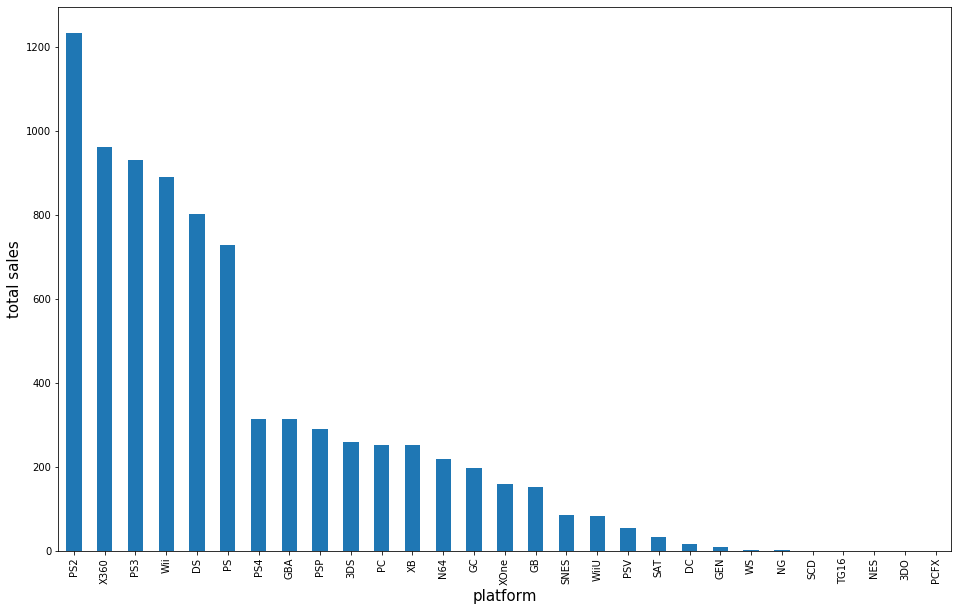

In [13]:
#Список платформ с суммарными продажами:
platform_sales = (
    new_games
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values('total_sales', ascending=False)
)

#Построю гистограмму, чтобы найти самые популярные платформы:
platform_sales.plot(kind='bar', figsize=(16, 10), legend=False)
plt.xlabel('platform', fontsize=15)
plt.ylabel('total sales', fontsize=15)

Если отсортировать игровые платформы по суммарным продажам, то легко заметить шесть явных лидеров: PS2, X360, PS3, WII, DS и PS. Выделю их в отдельную таблицу и изучу продажи по годам.

In [14]:
#Создал список из 6 самых популярных платформ:
popular_platforms = platform_sales.loc[platform_sales['total_sales'] > 400].index

#Создал сводную таблицу продаж по годам для самых популярных платформ:
popular_platform_sales = (
    new_games
    .loc[new_games['platform'].isin(popular_platforms)]
    .pivot_table(index='platform', columns='year_of_release',values='total_sales', aggfunc='sum')
)

popular_platform_sales

year_of_release,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
PS,6.03,35.96,94.7,136.17,169.49,144.53,96.37,35.59,6.67,2.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS2,NaN,NaN,NaN,NaN,NaN,NaN,39.17,166.43,205.38,184.31,...,75.99,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN
PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.41,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52


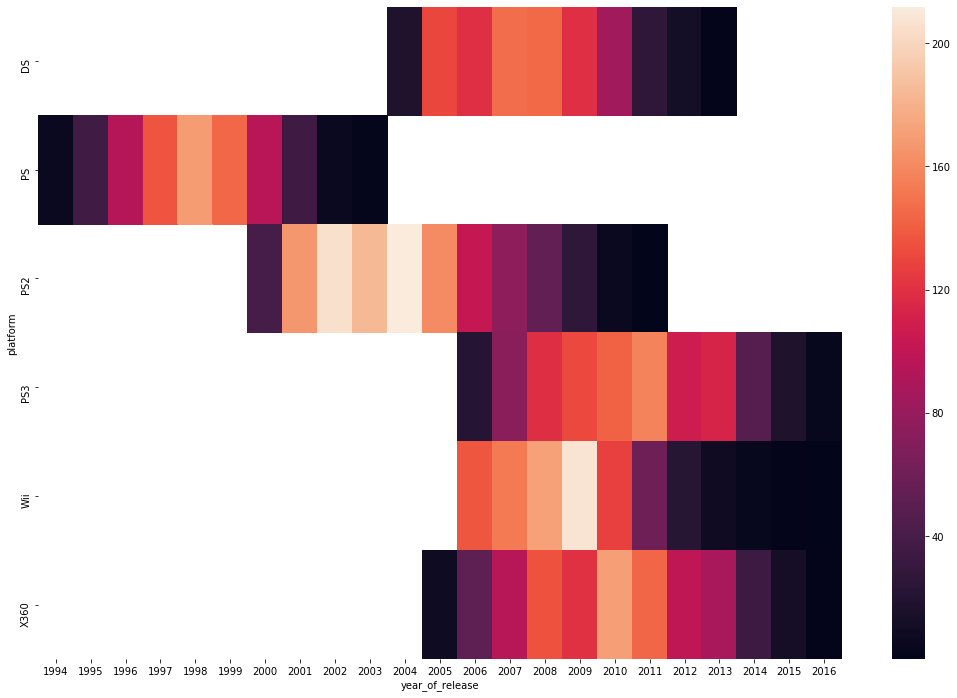

In [15]:
#Построил "тепловую карту" продаж по годам самых популярных платформ:
plt.figure(figsize=(18, 12))
sns.heatmap(popular_platform_sales)

Из графика выше видно, что успешные игровые платформы "живут" всего около 6-8 лет, а потом вытесняются более современными и забываются. А для трех версий PlayStation можно проследить простую закономерность - падение популярности к ранней версии совпадает во времени с появлением новой. Можно сделать вывод, что 7 лет - средний срок "жизни" игровой платформы, через такой же промежуток времени исчезаю старые платформы, и появляются новые.

Зная время существования игровой платформы на рынке можно выделить актуальный период для прогнозирования развития игровой индустрии на следующий год. Предлагаю далее рассматривать только данные за последние пять лет: существующие успешные платформы уже пересекли пик выпуска игр, но популярность их будет плавно снижаться еще 2-4 года, а новые платформы, наоборот, будут набирать популярность, и при анализе данных можно будет "отловить" их.

In [16]:
#Выделил новую таблицу для данных за актуальный период (5 лет):
actual_games = new_games[new_games['year_of_release'] > 2011]

In [18]:
#Создал сводную таблицу продаж по годам для платформ актуального периода:
actual_platform_sales = (
    actual_games
    .pivot_table(index='year_of_release', columns='platform',values='total_sales', aggfunc='sum')
)

Text(0, 0.5, 'total sales')

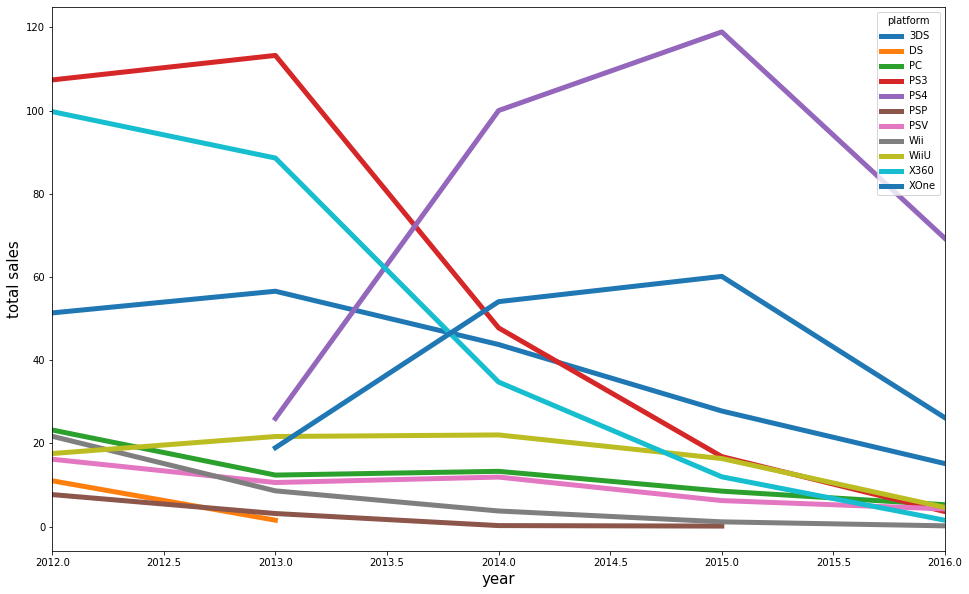

In [19]:
#Построил графики изменения продаж игр на актуальные платформы:
actual_platform_sales.plot(figsize=(16, 10), linewidth=5)
plt.xlabel('year', fontsize=15)
plt.ylabel('total sales', fontsize=15)

Из графика выше можно выделить три группы платформ:
1. Нишевые. Им соответствуют линии, близкие горизонтальным, в нижней части графика. На протяжении всего рассматриваемого периода новые игры на них выходили в небольшом размере без заметных взлетов и падений.
2. Стареющие. Это PS3, X360 и 3DS (последнюю можно также отнести и к нишевым) - их графики стремятся к нулю с движением вправо по временной шкале.
3. Новые. Платформы PS4 и XOne, продажи игр на которые растут. За 2016 год видно падение, но оно вызвано тем, что данные за этот год неполные.

Кроме того видно, что самые современные игровые платформы (PS4 и XOne) появились в 2013 году, они же входят в группу растущих, а значит именно на них можно сделать ставку в 2017 году.

(0, 2)

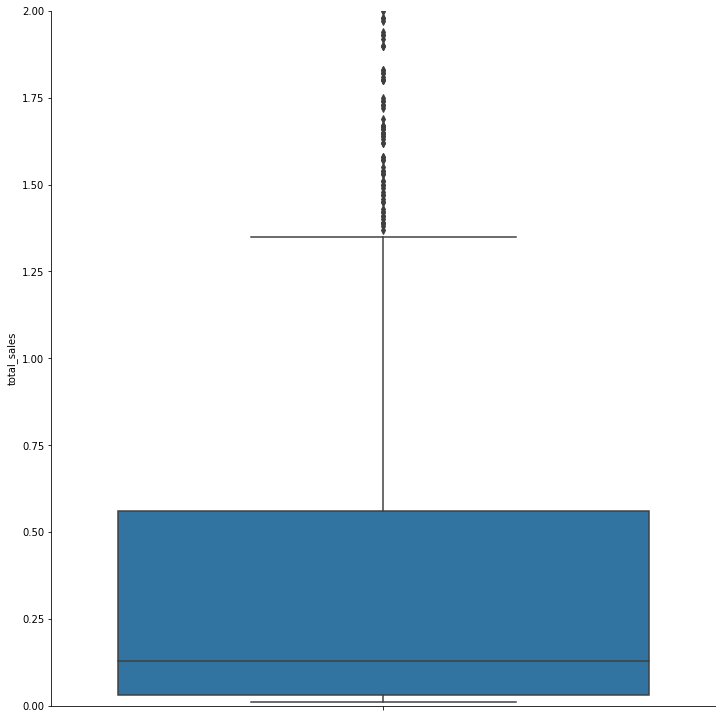

In [20]:
#Создал сводную таблицу по общим продажам каждой игры вне зависимости от платформы:
actual_games_all_platforms = actual_games.pivot_table(index='name', values='total_sales', aggfunc='sum')

#Построил график boxplot для этой сводной таблицы, чтобы найти типичные значения продаж:
sns.catplot(y="total_sales", kind="box", height=10, data=actual_games_all_platforms)
plt.ylim(0, 2)

По графику видно, что типичные игры на всех платформах продаются с тиражом до 600 тысяч штук. 75% игр продаются меньше 1.35 миллиона раз, медиана - примерно 150 тысяч. Типичные игры различаются в продажах на несколько сотен тысяч штук.

(0, 3)

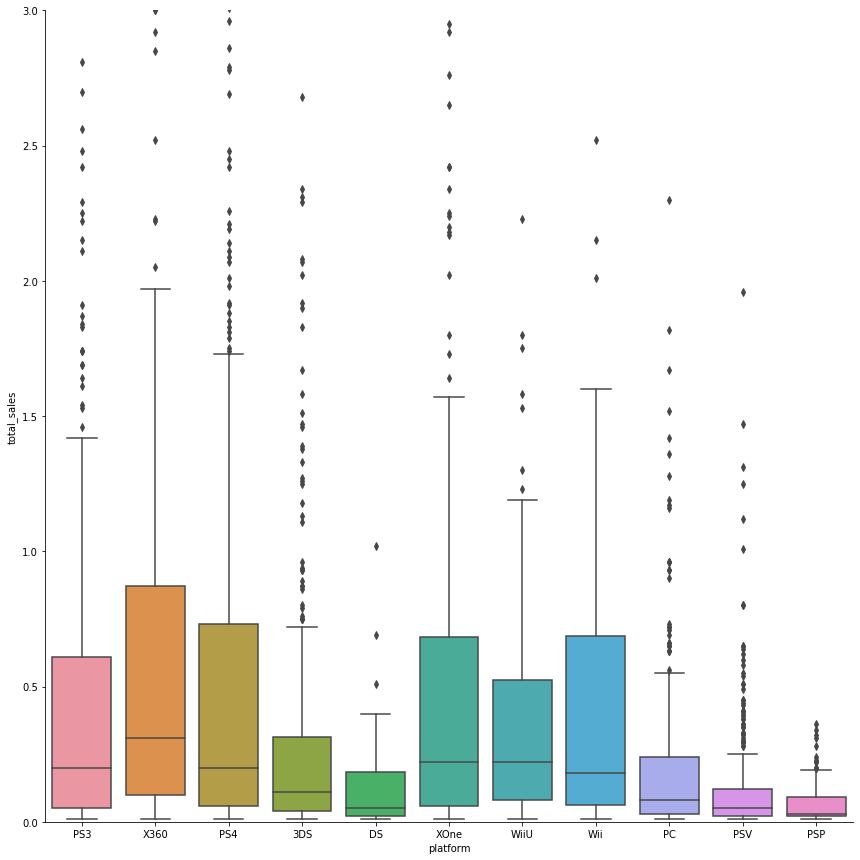

In [21]:
#Построил график boxplot по продажам отдельно для каждой платформы:
sns.catplot(x='platform', y="total_sales", kind="box", height=12, data=actual_games)
plt.ylim(0, 3)

Платформы по глобальным продажам игр можно разделить на две группы: популярные и нишевые. Медианные продажи игр на популярные платформы выше межплатформенных продаж, а продажи нишевых - равны или ниже. Еще проще их выделить по третьему квартилю на графике: у популярных он выше 500 тысяч, а у нишевых - сильно ниже.

Интересно выяснить как продажи игр зависят от оценок пользователей и критиков. Изучу зависимость для платформы X360:

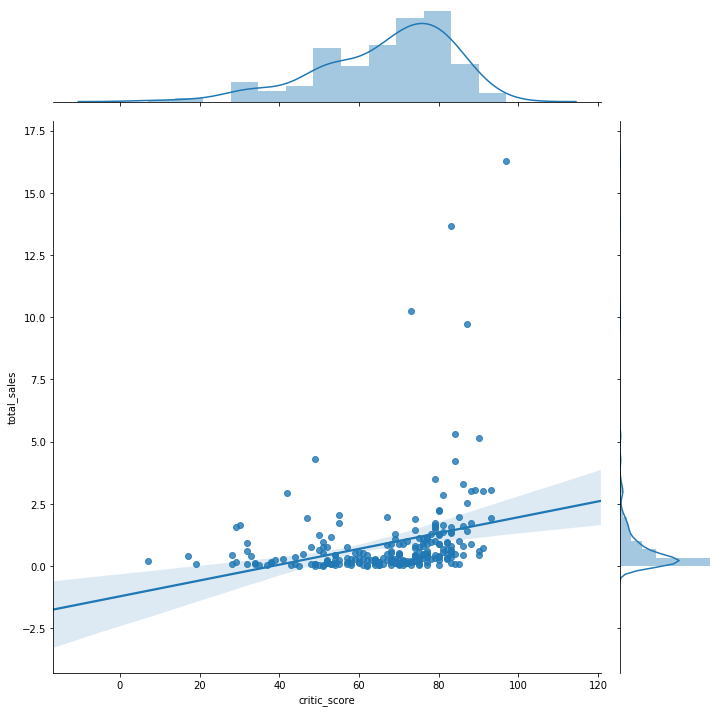

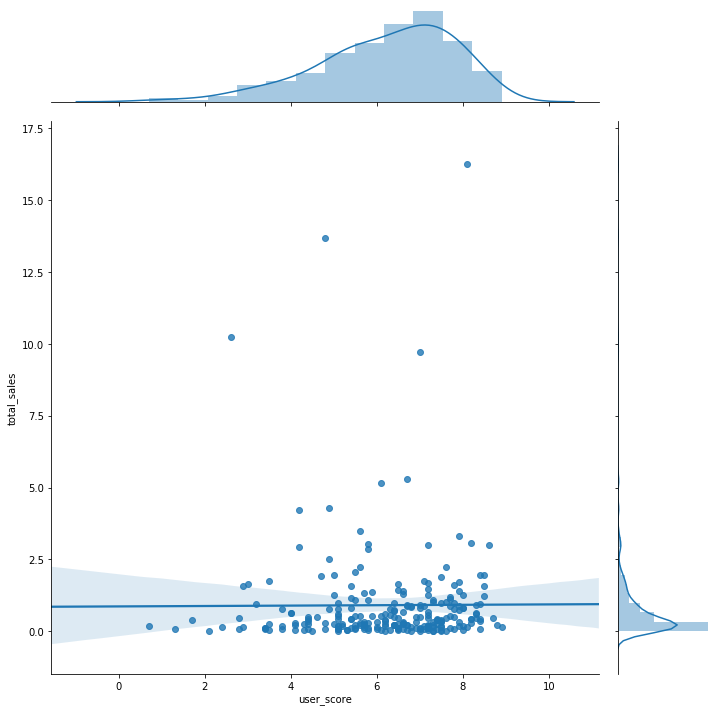

In [22]:
#Построил диаграммы рассеяния для поиска зависимости продаж от оценок критиков и игроков соответственно:
for i in ['critic_score', 'user_score']:
    sns.jointplot(x=i, y='total_sales', data=actual_games[actual_games['platform'] == 'X360'], kind='reg', height=10)

In [23]:
#Посчитал коэффициенты корреляции продаж и оценок (соответственно критиков и игроков):
for i in ['critic_score', 'user_score']:
    print(actual_games[actual_games['platform'] == 'X360'][i]
          .corr(actual_games[actual_games['platform'] == 'X360']['total_sales']))

0.2895693929887809
0.006163978646213326


Диаграммы рассеяния и коэффициенты корреляции говорят об одном и том же: высокие оценки критиков оказывают небольшое положительное влияние на продажи игр, а оценки игроков в свою очередь практически не имеют значения.

Теперь было бы неплохо проверить это утверждение для других игровых платформ:

In [24]:
#Вычислил коэффициенты корреляции между оценками и продажами для каждой актуальной платформы по отдельности:
for i in list(actual_games['platform'].unique()):
    print(i, ':')
    print('Критики:',
          actual_games[actual_games['platform'] == i]['critic_score']
          .corr(actual_games[actual_games['platform'] == i]['total_sales']))
    print('Игроки',
          actual_games[actual_games['platform'] == i]['user_score']
          .corr(actual_games[actual_games['platform'] == i]['total_sales']))
    print()

PS3 :
Критики: 0.23906906332620015
Игроки -0.0023582381963256193

X360 :
Критики: 0.2895693929887809
Игроки 0.006163978646213326

PS4 :
Критики: 0.40090322359256714
Игроки -0.032458648363711894

3DS :
Критики: 0.28778181017459753
Игроки 0.2089467954786616

DS :
Критики: 0.8568648534955052
Игроки 0.88270872757644

XOne :
Критики: 0.4071713295687383
Игроки -0.06383819139818166

WiiU :
Критики: 0.36293754541815515
Игроки 0.39740231364973433

Wii :
Критики: 0.3004788446690132
Игроки 0.29619680007479526

PC :
Критики: 0.23797293165418587
Игроки -0.12226467707135899

PSV :
Критики: 0.027319647097647774
Игроки -0.003225630289851218

PSP :
Критики: -0.8097263323583076
Игроки -0.802302061939321



На популярных платформах теория подтвердилась. Продажи игр зависят от оценок критиков и не зависят от оценок игроков на платформах PS3, X360, PS4 и XOne, причем на новых PS4 и XOne сильнее.

А вот на нишевых всё оказалось иначе: на 3DS, DS, Wii и WiiU продажи игр зависят примерно одинаково как от оценок критиков, так и от оценок пользователей (причем на DS очень сильно).

Также были получены довольно необычные результаты по PC, PSV и PSP. Зависимость продаж игр на PC от оценок критиков соответствует популярным платформам, а вот оценки пользователей показатели отрицательное влияние на продажи (впрочем совсем небольшое, возможно это особенности данных в выборке). Любые оценки на PSV почти не влияют на продажи. А на PSP высокие оценки и вовсе сильно отрицательно влияют на продажи.

Странно, что были получены настолько разные результаты, стоит проверить количество игр с оценками по каждой платформев выборке.

In [25]:
#Количество игр с оценками на каждой платформе в выборке:
for i in list(actual_games['platform'].unique()):
    print(i, ':', actual_games[(actual_games['platform'] == i) &
                               ~(actual_games['user_score'].isna()) &
                               ~(actual_games['critic_score'].isna())]['name'].count())

PS3 : 284
X360 : 235
PS4 : 260
3DS : 118
DS : 3
XOne : 186
WiiU : 101
Wii : 17
PC : 207
PSV : 131
PSP : 4


На DS, Wii и PSP записей в данных вместе с оценками очень мало, поэтому выводы из исследования выше по данным платформамм не нужно воспринимать серьезно.

Теперь изучу ситуацию с жанрами на игровом рынке.

In [26]:
#Посчитал количество игр определенного жанра в выборке:
actual_games['genre'].value_counts()

Action          1031
Role-Playing     370
Adventure        302
Sports           268
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

Построю гистограммы по количеству и общим продажам игр разных жанров:

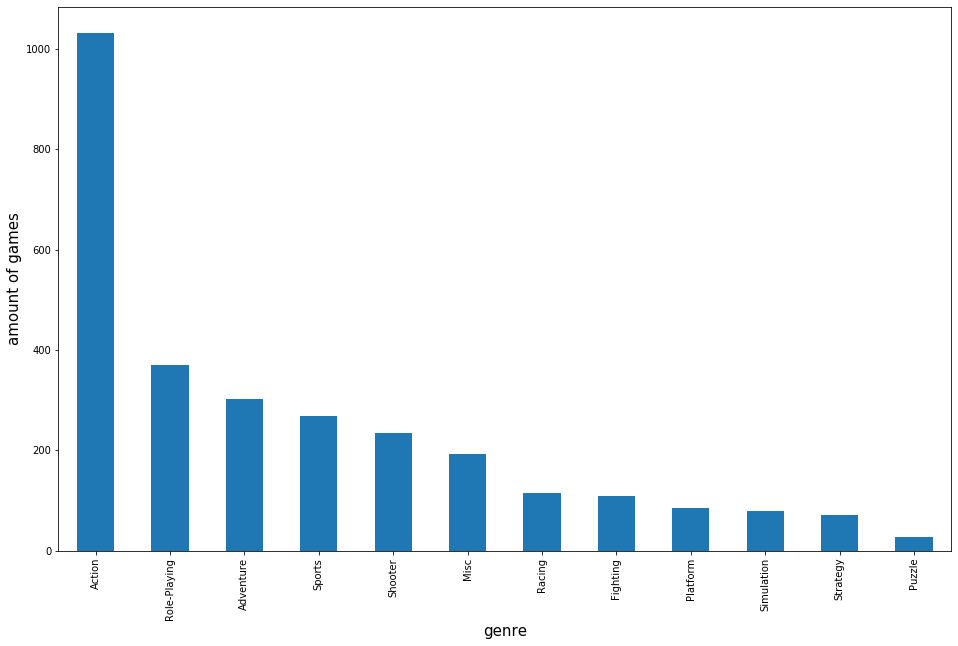

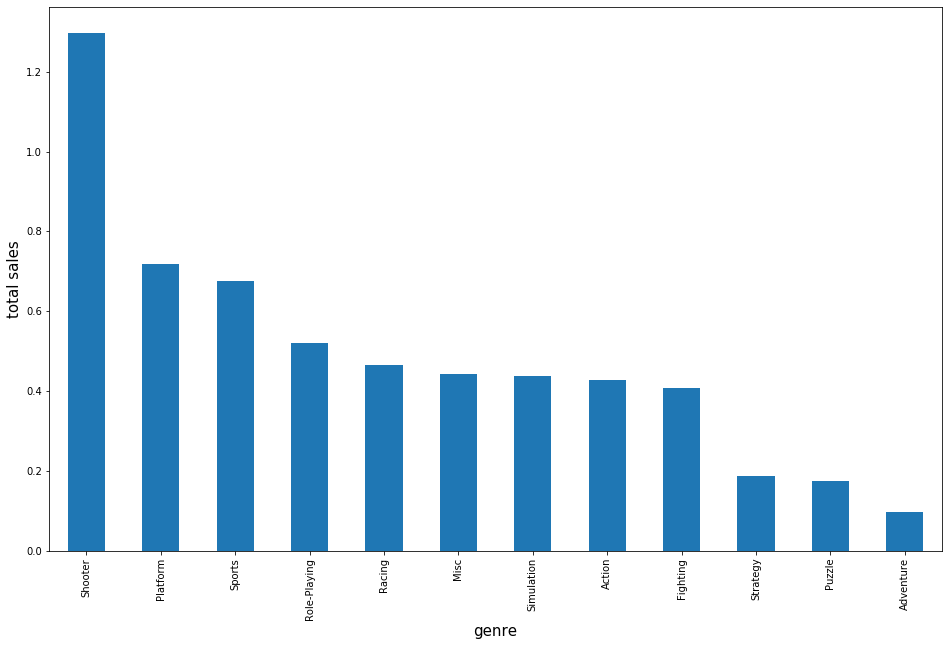

In [27]:
#Создал таблицы для изучения двух количественных показателей жанров игр:
genre_count = actual_games['genre'].value_counts()
genre_sales = (
    actual_games
    .pivot_table(index='genre', values='total_sales', aggfunc='mean')
    .sort_values(by='total_sales', ascending=False)
)

#Построил гистограммы:
for i in genre_count, genre_sales:
    i.plot(kind='bar', figsize=(16, 10), legend=False)
    if i is genre_count:
        plt.xlabel('genre', fontsize=15)
        plt.ylabel('amount of games', fontsize=15)
    else:
        plt.xlabel('genre', fontsize=15)
        plt.ylabel('total sales', fontsize=15)

С большим отрывом по количеству выпускаемых игр впереди Action. Довольно большую долю занимают игры в жанрах Role-Playing, Adventure, Sports и Shooter. Меньшей популярностью у разработчиков пользуются жанры Fighting, Platform, Simulation, Strategy и Puzzle. (Misc я опустил, потому что там могут быть совсем разные игры, непохожие друг на друга и трудно относимые к устоявшимся жанрам).

А вот по количеству продаж успешнее всех оказался жанр Shooter. Сильно отстают в продажах жанры Strategy, Puzzle и Adventure. Остальные жанры не сильно выделяются и имеют средние продажи.

Можно сказать, что у разработчиков и игроков немного разные взгляды на игровую индустрию. Например, выпускается относительно много игр в жанре Action, при том, что они обладают средними продажами, а хорошо продаваемые стрелялки выпускаются в не очень большом количестве. Разве что стратегии и паззлы мало интересны и разработчикам, и игрокам.

### Составление портрета пользователя каждого региона

По данным продаж игры в разных регионах можно многое понять об игроках из разных частей планеты. Начну изучение с популярности определенных игровых платформ.

In [28]:
#Добавил в таблицу с данными по играм актуального периода соотношение продаж в отдельных регионах к общим продажам:
actual_games['na_sales_ratio'] = actual_games['na_sales']/actual_games['total_sales']
actual_games['eu_sales_ratio'] = actual_games['eu_sales']/actual_games['total_sales']
actual_games['jp_sales_ratio'] = actual_games['jp_sales']/actual_games['total_sales']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [29]:
#Создал функцию и вывел топ-5 платформ для каждого региона:
def top_5(column):
    for i in ['na_sales', 'eu_sales', 'jp_sales']:
        print(actual_games.pivot_table(index=column, values=i, aggfunc='mean').sort_values(by=i, ascending=False).head())
        print()
        
top_5('platform')

          na_sales
platform          
X360      0.479623
XOne      0.377004
Wii       0.323148
PS4       0.277398
WiiU      0.259184

          eu_sales
platform          
PS4       0.359923
X360      0.255205
Wii       0.220741
PS3       0.216755
XOne      0.208866

          jp_sales
platform          
3DS       0.221692
DS        0.120000
WiiU      0.088503
PS3       0.071582
Wii       0.062778



В Северной Америке большую долю рынка занимают приставки X360 и XOne ("отечественного" для американцев производителя), причем новая XOne по доле продаж еще не перегнала X360 предыдущего поколения. В Европе по доле продаж лидирует новая PS4, а в Японии - 3DS (видимо, популярна платформа именно на азиатском рынке, потому что в два других "топа" она даже не попала). Что интересно, в японском топ-5 все платформы от японских компаний.

На североамериканский рынок приходится в среднем большая доля продаж по всем игровым платформам топ-5, чем на европейском, при том, что население Европы значительно больше. Похоже американцы больше увлекаются играми. На Японию приходятся значительно меньшие доли продаж, чем в Европе или Северной Америке, но и население Японии гораздо меньше.

In [30]:
#Вывел топ-5 жанров для каждого региона:
top_5('genre')

          na_sales
genre             
Shooter   0.616043
Sports    0.304216
Platform  0.298588
Misc      0.198906
Fighting  0.181560

            eu_sales
genre               
Shooter     0.482851
Sports      0.257799
Platform    0.251882
Racing      0.237304
Simulation  0.181875

              jp_sales
genre                 
Role-Playing  0.176865
Simulation    0.130125
Platform      0.101529
Fighting      0.086606
Puzzle        0.076429



Жанровые предпочтения игроков из Северной Америки и Европы оказались схожими: в топе шутеры, спортивные игры и платформеры. Все эти жанры занимают довольно высокую долю от мировых продаж (особенно шутеры). А вот в Японии ситуация кардинально отличается: шутеры и спортивные игры даже не вошли в топ, платформеры так же на третьем месте, а на пятом - паззлы, как было выяснено ранее - в общем не очень успешный жанр. Наверное сказывается разница западного и восточного менталитета.

Доли по жанрам в Японии также ниже из-за меньшего населения.

Теперь проверю влияет ли рейтинг игры на продажи в разных регионах:

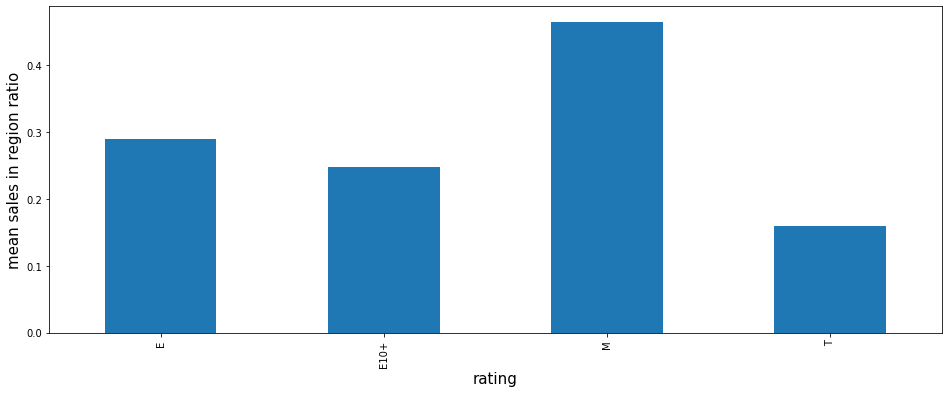

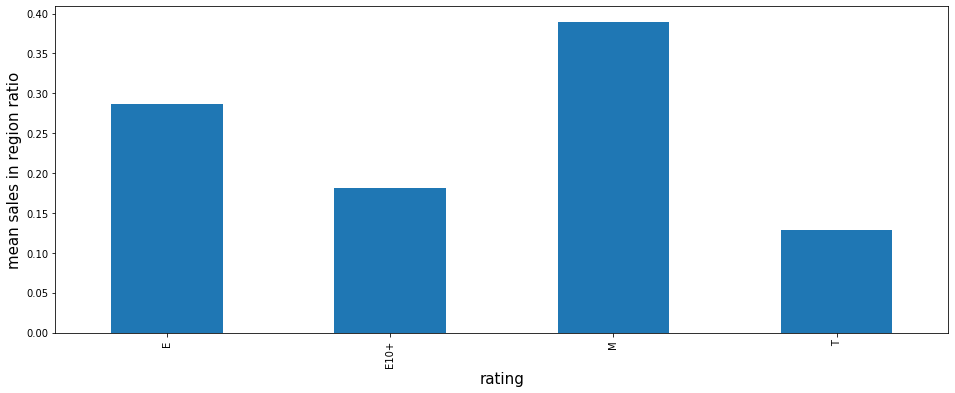

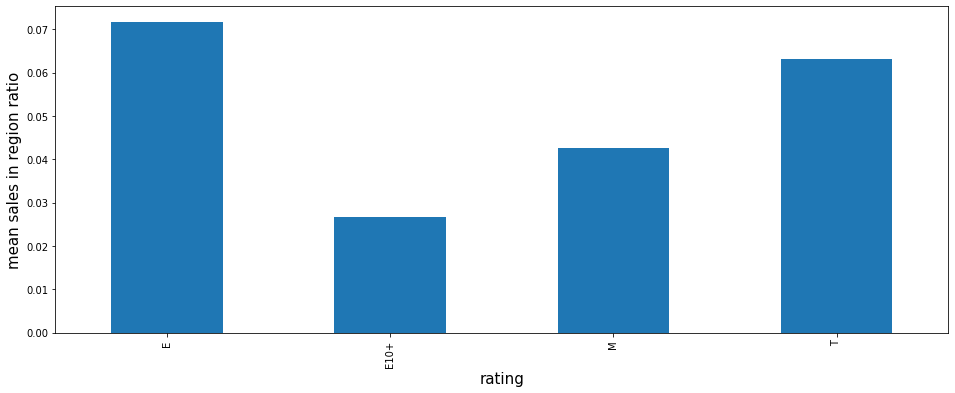

In [34]:
#Создал таблицу без пустых значений в столбце с рейтингом:
actual_games_with_rating = actual_games[~actual_games['rating'].isna()]

#Построил гистограммы по средней доле продаж игр в регионе в зависимости от рейтинга игры:
for i in ['na_sales', 'eu_sales', 'jp_sales']:
    actual_games_with_rating.pivot_table(index='rating', values=i, aggfunc='mean').plot(kind='bar', figsize=(16, 6), legend=False)
    plt.xlabel('rating', fontsize=15)
    plt.ylabel('mean sales in region ratio', fontsize=15)

Рейтинговые предпочтения пользователей из североамериканского и европейского регионов оказались схожими: наибольшей популярностью пользуются игры 17+ (рейтинг M), за ними следуют игры с более мягкими рейтингами 6+ и 10+ (Е и Е10+ соответственно). А в Японии лучше всего продаются игры с рейтингами 6+ и 13+ (Т), а уже после идут "взрослые" игры.

Можно предположить, что в Японии основными потребителями цифровых игр являются дети и подростки, а в Европе и Америке - взрослые люди. Но дело может быть и в разных предпочтениях жителей регионов, разных правилах дистрибуции, ценовой политике, доступности и прочем.

### Статистическая проверка гипотез

Выдвинута гипотеза, что средние пользовательские рейтинги платформ XOne и PC одинаковые. В библиотеке stats есть метод ttest_ind (проведение t-теста), сравнивающий среднее двух выборок и возвращающий p-value - вероятность того, что они равны.

In [55]:
#Вычислил средние значения пользовательских оценок игр на платформах PC и XOne:
for i in ['XOne', 'PC']:
    print(i, ':', actual_games[actual_games['platform'] == i]['user_score'].mean())

XOne : 6.512903225806452
PC : 6.430434782608695


In [42]:
#Вычислил дисперсии пользовательских оценок игр на платформах PC и XOne:
for i in ['XOne', 'PC']:
    print(i, ':', np.var(actual_games[actual_games['platform'] == i]['user_score'], ddof=1))

XOne : 1.8890217959895377
PC : 2.7576614605318697


Средние значения пользовательских оценок действительно выглядят похоже. Дисперсии выборок довольно сильно отличаются, поэтому в методе ttest_ind параметру equal_var передам значение False. Еще нужно выбрать уровень статистической значимости. Наше исследование не требует высокой точности, поэтому целесообразно задаться общепринятым значением 5% или 0.05. Если p-value будет меньше этого значения, то гипотеза будет отвергнута.

Итак, нулевая гипотеза "средние пользовательские рейтинги платформ XOne и PC одинаковые", альтернативная - "средние пользовательские рейтинги платформ XOne и PC разные."

In [50]:
alpha = .05 # критический уровень статистической значимости

#Для удобства выделил отдельные переменные для выборок:
xone_games = actual_games[(actual_games['platform'] == 'XOne') & (~actual_games['user_score'].isna())]['user_score']
pc_games = actual_games[(actual_games['platform'] == 'PC') & (~actual_games['user_score'].isna())]['user_score']

results = st.ttest_ind(xone_games, pc_games, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5907361767479966
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза подтверждена, средние пользовательские рейтинги платформ XOne и PC действительно одинаковые. Наверняка это вызвано тем, что одни и те же игры зачастую выходят и на PC и на приставках, поэтому пользовательские рейтинги игр близки.

Точно таким же образом можно сравнить пользовательские рейтинги игровых жанров action и sports:

In [57]:
action_games = actual_games[(actual_games['genre'] == 'Action') & (~actual_games['user_score'].isna())]['user_score']
sports_games = actual_games[(actual_games['genre'] == 'Sports') & (~actual_games['user_score'].isna())]['user_score']

In [60]:
#Вычислил средние значения пользовательских оценок жанров action и sports:
for i in ['Action', 'Sports']:
    print(i, ':', actual_games[actual_games['genre'] == i]['user_score'].mean())

Action : 6.817267552182162
Sports : 5.442639593908629


In [61]:
#Вычислил дисперсии пользовательских оценок игр жанров action и sports:
for i in ['Action', 'Sports']:
    print(i, ':', np.var(actual_games[actual_games['genre'] == i]['user_score'], ddof=1))

Action : 1.8924959415877232
Sports : 3.0105195276079977


Дисперсии в выборках отличаются, параметру equal_var передам False. Средние выборок тоже отличаются, но насколько это статистически значимо нужно проверить. Критический уровень предлагаю так же, как в прошлом случае, принять равным 0.05

Нулевая гипотеза - "Средние пользовательские рейтинги жанров Action и Sports разные", альтернативная - "Средние пользовательские рейтинги жанров Action и Sports одинаковые."

In [64]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(action_games, sports_games, equal_var=False)

print('p-значение:', results.pvalue)

#В данном случае проверяю не равенство средних, а их различие:
if ~(results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.8174388269289055e-20
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получается, а значит средние пользовательские рейтинги action и sports действительно одинаковые. Можно предположить, что аудитории экшен- и спортивных игр не похожи друг на друга и слабо пересекаются, и критерии оценки у них разные.

### Общий вывод

В работе исследовалась крупная выборка данных по играм на разных платформах за большой промежуток времени. Исходная информация об играх: платформа, жанр, продажи в разных регионах, оценки пользователей и критиков и прочее. В данных были обнаркужены некоторые проблемы: не совсем удобные названия и типы данных столбцов, большое количество пропусков. В процессе предобработки они были частично устранены.

Целью исследования было выявить закономерности, определяющие степень успешности игры, и после комплексного анализа данных можно дать следующие рекомендации для продвижения игр на 2017 год:
- Среднее время "жизни" игровой платформы примерно 7 лет, поэтому упор в продвижении нужно делать на новые платформы. В 2013 году появились две платформы: Xbox One и PS4, в 2017 году их потенциал еще не будет исчерпан, и игры на них будут хорошо продаваться. А вот на продвижение игр на устаревающие Xbox360 и PS3 лучше не тратить много ресурсов
- По графику продаж игр среди разных платформ лучшие результаты показали именно Xbox One и PS4, в 2017 году их продажи скорее всего тоже будут на высоте
- Игры с высокими оценками критиков лучше продаются, поэтому для разработки эффективной стратегии продвижения необходимо мониторить сайты с обзорами (или агрегаторы) и больше ресурсов тратить на продвижение высоко оцененных игр. Оценки игроков почти не влияют на продажи, поэтому на них можно не обращать внимания (Исключение составили WiiU и 3DS, эти платформы можно исследовать дополнительно)
- Лучше всего продаются шутеры, затем платформеры, спортивные игры и RPG. Но в отношении жанров лучше иметь в виду региональную специфику (об этом далее)
- В Северной Америке и Европе действительно лучше продаются шутеры, платформеры и спортивные игры, а вот на Японском рынке всё совсем не так: там более популярны RPG, симуляторы, платформеры, а также файтинги и паззлы (жанр с низкими общими продажами в выборке)
- Также стоит обращать внимание на продвижение игр в зависимости от платформы. Так в Северной Америке большей популярностью пользуются Xbox'ы, и продвижением игры на Xbox One нужно заняться поплотнее, чем на PS4. Еще довольно популярными в регионе являются специфичные Wii и WiiU. В Европе, напротив, PlayStation занимает лучшие позиции, нежели Xbox, и упор в 2017 лучше сделать на PS4. А в Японии популярны японские платформы от Nintendo и Sony.
- Относительно рейтинга ESRB, в североамериканском и европейском регионе большими продажами отличаются игры для взрослых (рейтинг М, или 17+), так что при проектировании рекламного бюджета можно не опасаться строгих рейтингов. В Японии ситуация иная: Ведут рейтинги Е и Т (6+ и 13+ соответсвенно), а "взрослые" игры по продажам отстают, поэтому в этом регионе эффективнее продвигать игры с мягким рейтингом